- Started on July 31, 2019
- Works with a subset of the highd dataset
- Goal is to run particle filtering on this highd dataset with the
ultimate aim of learning idm rules for driver modeling
- Trivia: Timestep is 0.04 sec, each vehicle is visible for median duration of
13.6 seconds. This translates to about 340 timesteps of visibility. We have verified
this by starting from scene 1 and going till 340 looking at truck vehicle id 27

## Needs experimentation
- Should the particle fitness be based on likelihood of hallucinated x location
under Gaussian centered around true x location? Or should this also include
y? Reason for asking this question is because Frenet s is 0 all the time so
we will need to work with posG i.e. global position

## Needs investigation
- Why is Frenet s always 0?

In [1]:
using NGSIM
using AutomotiveDrivingModels
using AutoViz
using Interact # Make video in notebook
using Reel # Save video as gif
using CSV # For writing to csv
using DataFrames # For writing to csv
using PyPlot # For in notebook plotting
using Distributions
using Test

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-8640779364712014339\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12477508767560951214\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/edf674b4a352d3049d1cf8e1b8f9eda882001cd6-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-8640779364712014339\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

In [3]:
# The trajectories i.e. positions of the cars with timestep
traj_highd = open(io->read(io, MIME"text/plain"(), Trajdata), 
    "trajdata_Data11_Road1_nLIOD3_lower.txt", "r");
# The highd roadway geometry
roadway_highd = open(io->read(io, MIME"text/plain"(), Roadway), 
    "ngsim_11_lower.txt", "r");

In [82]:
# Make a video replaying the highd trajectories on the roadway and save it into media
frames = Frames(MIME("image/png"), fps=10)
scene = Scene(500)
for i in 1:100
    temp_scene = get!(scene,traj_highd,i)
    carcolors = Dict{Int,Colorant}()
    for veh in temp_scene
        #@show veh.id
        #carcolors[veh.id] = in(veh.id, egoid) ? colorant"blue" : colorant"green"
        
            # Color cars green when they are in segment 3
        if veh.state.posF.roadind.tag.segment == 3
            carcolors[veh.id] = colorant"green"
        end
        
    end
    overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, 
                pos=VecSE2(veh.state.posG.x+0.5,veh.state.posG.y+0.5)) for veh in scene]
    scene_visual = render(temp_scene, roadway_highd, 
        #cam=CarFollowCamera{Int}(2,5.0),
        #cam=StaticCamera(VecE2(1966400, 570900), 5.0),
        cam=FitToContentCamera(0.),
        overlays,
        car_colors=carcolors)
    push!(frames,scene_visual)
end
write("media/highd_short.gif",frames)

"media/highd_short.gif"

In [65]:
scene = Scene(500)
temp = get!(scene,traj_highd,30)
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, 
                pos=VecSE2(veh.state.posG.x+0.5,veh.state.posG.y+0.5)) for veh in scene]
render(temp,roadway_highd,overlays)
for veh in scene
    print("veh id = $(veh.id) and veh speed  = $(veh.state.v)\n")
end

veh id = 1 and veh speed  = 30.76016353266035
veh id = 3 and veh speed  = 33.42007437875751
veh id = 6 and veh speed  = 32.72000715950906
veh id = 9 and veh speed  = 27.8300080770487
veh id = 10 and veh speed  = 32.71005607571858
veh id = 11 and veh speed  = 31.71000259150967
veh id = 13 and veh speed  = 33.5105979037893
veh id = 14 and veh speed  = 33.54025301032634
veh id = 17 and veh speed  = 32.980669635627
veh id = 19 and veh speed  = 32.90000257255685
veh id = 20 and veh speed  = 32.280100165400796
veh id = 21 and veh speed  = 30.64032082216291
veh id = 23 and veh speed  = 31.200161254403817
veh id = 27 and veh speed  = 22.730141510034553
veh id = 35 and veh speed  = 33.27018290965533
veh id = 38 and veh speed  = 31.34000100288
veh id = 39 and veh speed  = 27.480000879360002


In [ ]:
# For overlaying hallucination on the ground truth
# Borrowed from visualization_functions.jl
struct my_overlay <: SceneOverlay
    scene::Scene
    color # Needs to be of form colorant"Colorname"
end

"""
Render method for `my_overlay`. Helpful for making the color choice
"""
function AutoViz.render!(rendermodel::RenderModel,overlay::my_overlay, 
        scene::Scene, roadway::Roadway)
    AutoViz.render!(rendermodel,overlay.scene,car_color = overlay.color)
    return rendermodel
end

In [68]:
# Hallucination attempt
scene = Scene(500)
temp = get!(scene,traj_highd,100)
models = Dict{Int,DriverModel}()
for veh in scene
    models[veh.id] = IntelligentDriverModel(v_des=30.0)
end
n_steps = 40
dt = 0.04 # To match the timestep of traj_highd, ngsim was timestep 0.1
rec = SceneRecord(n_steps,dt)
simulate!(rec,scene,roadway_highd,models,n_steps)

SceneRecord(nscenes=40)

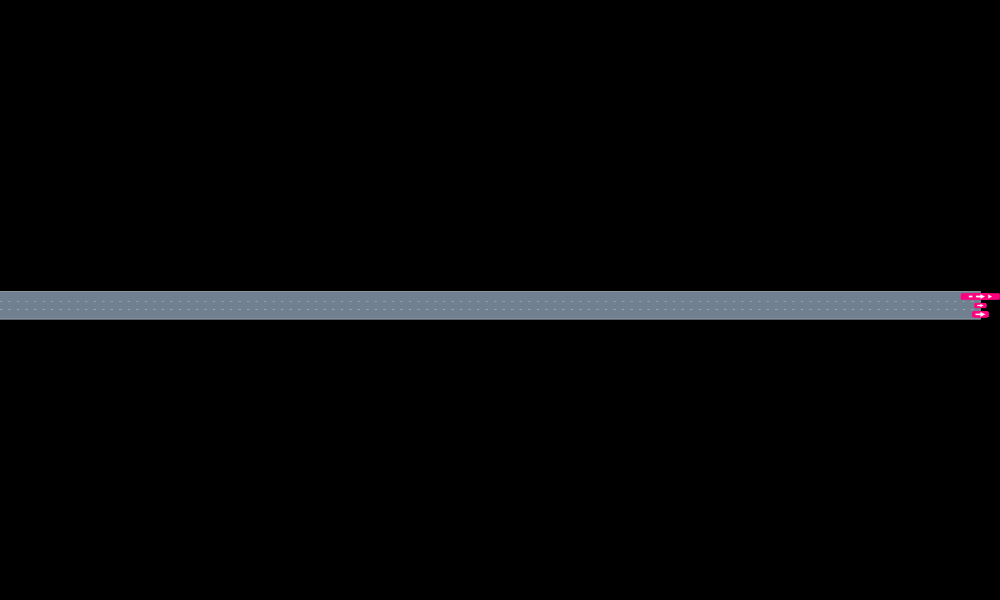

In [71]:
render(rec[-1],roadway_highd,cam=FitToContentCamera(0.))
# for veh in rec.frames[1]
#     display(veh.id)
# end

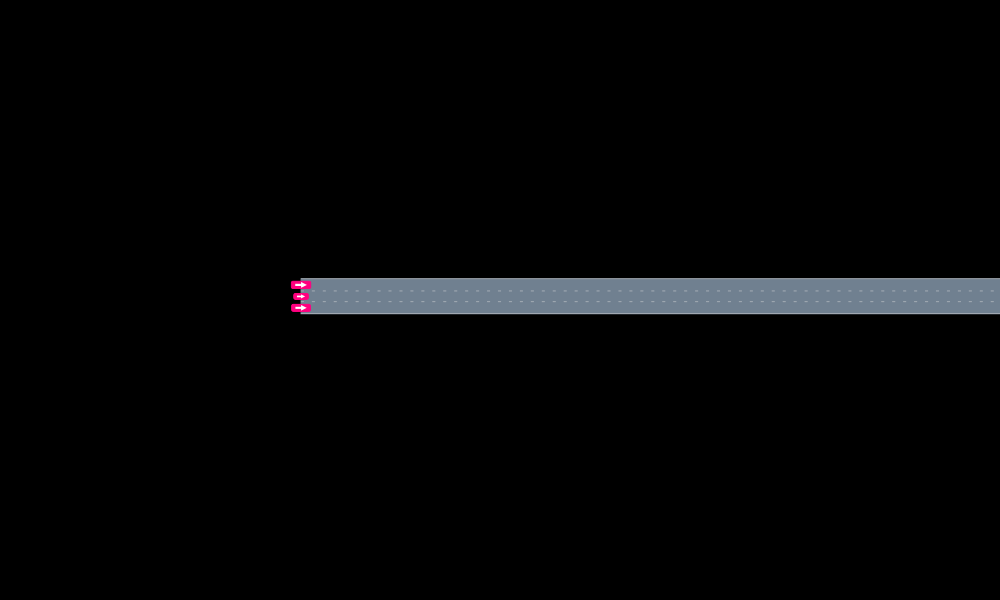

In [45]:
render(temp,roadway_highd)

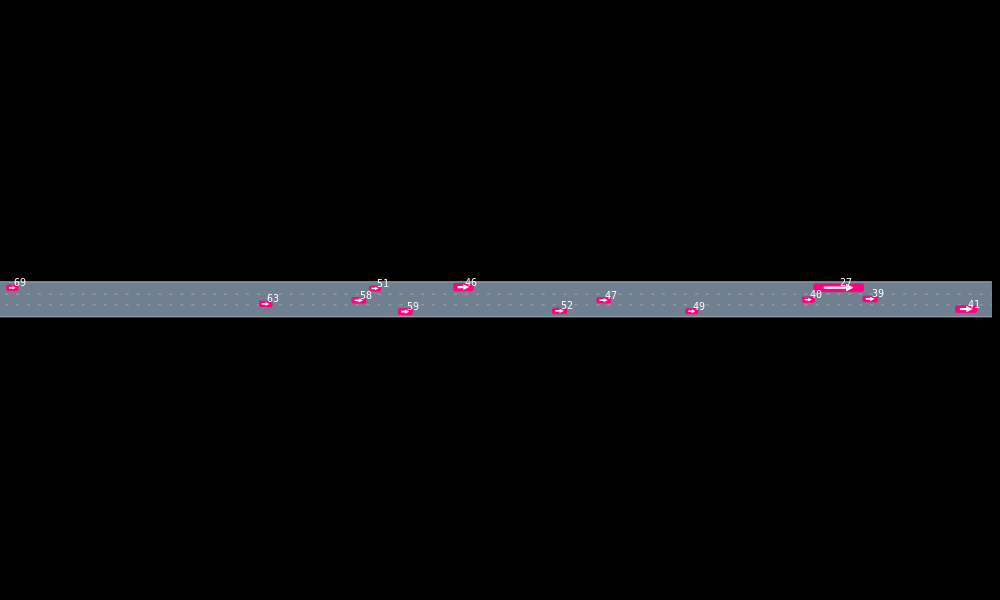

In [55]:
scene = Scene(500)
temp = get!(scene,traj_highd,350)
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, 
                pos=VecSE2(veh.state.posG.x+0.5,veh.state.posG.y+0.5)) for veh in scene]
render(temp,roadway_highd,overlays)